# Linear Regression - Closed-Form vs. Gradient Descent

In this notebook, I wanted to explore linear regression through two different techniques. Gradient Descent is a general algorithm that can be applied to many different problems. Linear Regression is a simple and closed-form problem that doesn't need gradient descent, however it gives us a simple case to explore the relationship between the two. Hopefully, we can provide some insight on how gradient descent works and how we can generalize it to harder problems.

## Setup

Let's load some packages and our data.

In [175]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')  #  because I like this style the best

from sklearn import datasets

boston = datasets.load_boston()

crime = pd.DataFrame(boston.data[0], columns=['crime'])  # per capita crime rate by town
indus = pd.DataFrame(boston.data[2], columns=['indus'])  # proportion of non-retail business by town
df = pd.concat([crime, indus], axis=1)

In [176]:
df.describe()

,crime,indus
count,13.000000,13.000000
mean,62.376871,56.882953
std,128.926582,120.765781
min,0.000000,0.000000
25%,1.000000,0.469000
50%,4.980000,4.967100
75%,18.000000,17.800000
max,396.900000,392.830000


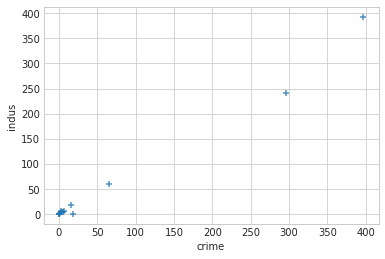

In [177]:
sns.regplot(x='crime', y='indus', data=df, marker='+', fit_reg=False)

I picked the boston dataset and these two variables beacuse they exhibit a strong correlation we can build a linear regressor on. More Industry = More Crime.

Let's go ahead and define an error function, and some statstical measurements

In [178]:
def mean_squared_error(x_arr, y_arr, m, b):
    """Computes Mean Squared Error for Linear Regression

    Args:
        x: numpy array of predictor values
        y: numpy array of response values
        m: slope
        b: y-intercept

    Returns:
        Mean Squared Error

    """
    mse = 0
    for x, y in zip(x_arr, y_arr):
        y_hat = m * x + b
        residual = y - y_hat
        mse += residual ** 2
    mse /= len(x_arr)
    
    return mse
    
def r_squared(x_arr, y_arr, m, b):
    """Coefficient of Determination (r^2) for Linear Regression

    Args:
        x: numpy array of predictor values
        y: numpy array of response values
        m: slope
        b: y-intercept

    Returns:
        r squared
    """
    # sum of squares of residuals
    ssr = 0
    for x, y in zip(x_arr, y_arr):
        y_hat = m * x + b
        residual = y - y_hat
        ssr += residual ** 2
    
    # total sum of squares
    y_bar = np.mean(y_arr)
    sst = 0
    for i, y in enumerate(y_arr):
        sst += (y - y_bar) ** 2
    
    return 1 - (ssr/sst)    

## Closed Form Regression

$\hat{w} = (\mathbf{X}^\intercal \mathbf{X})^{-1}\mathbf{X}^\intercal y$

Linear Regression has a closed-form equation (as seen above), that can allow us to calculate a line of best fit without messing with gradients. It calculates our slope and intercept with the weights array, w.

In [179]:
crime_arr = df.crime.as_matrix()
indus_arr = df.indus.as_matrix()

crime_arr = np.c_[crime_arr, np.ones(len(crime_arr))]  # add 1's for intercept term

w_hat = np.dot(np.linalg.inv(np.dot(crime_arr.T, crime_arr)), np.dot(crime_arr.T, indus_arr))  # estimate weights, w

crime_arr = crime_arr[:,0]  # remove 1's because we only needed them for calculation

print(w_hat)
print("y = {0:.3f}x + {1:.3f}".format(w_hat[0], w_hat[1]))

[ 0.93140336 -1.21507374]
y = 0.931x + -1.215


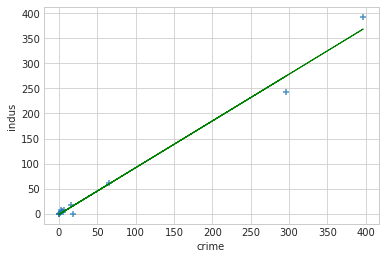

In [180]:
ax = sns.regplot(x='crime', y='indus', data=df, marker='+', fit_reg=False)
ax.plot(crime_arr, w_hat[1] + w_hat[0] *  crime_arr, color='g', linestyle='-', lw = 1)

Let's calculate the Mean Squared Error

In [181]:
print(mean_squared_error(crime_arr, indus_arr, w_hat[0], w_hat[1]))

151.8745813861948


... and $r^{2}$ (coefficient of determination) to see how good of a predictor it is. The closer to 1, the better.

In [182]:
print(r_squared(crime_arr, indus_arr, w_hat[0], w_hat[1]))

0.9887186932193579


## Gradient Descent Regression

Let's define our gradient step function. Here we compute the sum of all the gradients of the points to give us a direction to adjust each of our parameters. We then adjust them based on a learning rate so we can slowly converge to a solution, rather than jump erradically over it.

In [183]:
def step_gradient(x_arr, y_arr, m_curr, b_curr, learning_rate):
    m_gradient = 0.0
    b_gradient = 0.0
    
    N = len(x_arr)
    for i in range(0, N):
        # Differentiate error (MSE) function with respect to both parameters
        m_gradient += -(2/N) * x_arr[i] * (y_arr[i] - ((m_curr * x_arr[i]) + b_curr))
        b_gradient += -(2/N) * (y_arr[i] - ((m_curr*x_arr[i]) + b_curr))
        
    new_m = m_curr - (learning_rate * m_gradient)
    new_b = b_curr - (learning_rate * b_gradient)
    
    return (new_m, new_b)

This will calculate the gradient one time and return a new slope and intercept. The size of the step is dependant on learning rate.

In [184]:
# Let's set some inital values. These numbers are arbitrary, and the best values are different for every problem.
m = 0
b = 0
num_iterations = 1000000
learning_rate = 0.00001

for i in range(num_iterations):  # we compute gradients, and update slope and intercept while slowly converging to the correct solution. 
    m, b = step_gradient(crime_arr, indus_arr, m, b, learning_rate)
    
print("y = {0:.3f}x + {1:.3f}".format(m, b))

y = 0.931x + -1.215


Let's again calculate Mean Squared Error and $r^2$

In [185]:
print(mean_squared_error(crime_arr, indus_arr, m, b))

151.87458138619502


In [186]:
print(r_squared(crime_arr, indus_arr, m, b))

0.9887186932193579


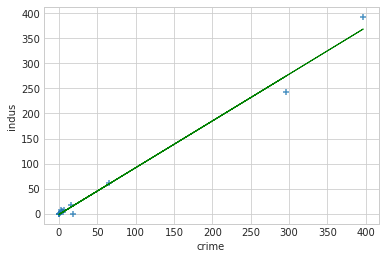

In [187]:
ax = sns.regplot(x='crime', y='indus', data=df, marker='+', fit_reg=False)
ax.plot(crime_arr, b + m *  crime_arr, color='g', linestyle='-', lw = 1)

As you can see, you will get the same solution for both. The advantage of a close form solution is they are generally faster on small datasets, and are considered tractable. Gradient Descent on the otherhand is generally slower, and there is no guarantee you'll find a solution. The advantage of gradient descent is you can apply it generally to problems that may not have closed form solutions, and it can be tweaked to find solutions more efficiently on vary large dataset by using batches.